In [1]:
import ee
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AfgeXvvftEVTCupdEusOPBLkfzEIqVH0-ixIpO9DVOjxgJ2eh8cfYA67Yyc

Successfully saved authorization token.


In [2]:
def clipper(image, shp_file):
    return image.clip(shp_file)

def spei(dataset):
    precipitation = dataset.select('pr').rename('Pp')
    pet = dataset.select('pet').multiply(0.1).rename('PET')
    
    time = dataset.get('system:time_start')
    
    return precipitation.subtract(pet).multiply(0.01).rename('SPEI').set('system:time_start', time)

In [3]:
shp_argentina = ee.FeatureCollection('users/adelarja/Hidro2022/Prov_Arg')

In [4]:
start_date = ee.Date.fromYMD(2000, 1, 1)
end_date = ee.Date.fromYMD(2022, 11, 1)

In [5]:
dataset = ee.ImageCollection(
    'IDAHO_EPSCOR/TERRACLIMATE').filterDate(
    start_date, end_date).map(
    lambda x: clipper(x, shp_argentina)
)

dataset_spei = dataset.map(spei)

In [6]:
 palette = [
    '1a3678', '2955bc', '5699ff', '8dbae9', 'acd1ff', 'caebff', 'e5f9ff',
    'fdffb4', 'ffe6a2', 'ffc969', 'ffa12d', 'ff7c1f', 'ca531a', 'ff0000',
    'ab0000'
]
palette = ['red', 'orange', 'yellow', 'lightgreen', 'green', 'lightblue', 'blue']
petVis = {
    'min': -2,
    'max': 2,
    'palette': palette
}

In [7]:
import folium

# Define a method for displaying Earth Engine image tiles on a folium map.
def add_ee_layer(self, ee_object, vis_params, name):
    
    try:    
        # display ee.Image()
        if isinstance(ee_object, ee.image.Image):    
            map_id_dict = ee.Image(ee_object).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)

        # display ee.ImageCollection()
        elif isinstance(ee_object, ee.imagecollection.ImageCollection):    
            ee_object_new = ee_object.mosaic()
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)

        # display ee.Geometry()
        elif isinstance(ee_object, ee.geometry.Geometry):    
            folium.GeoJson(
            data = ee_object.getInfo(),
            name = name,
            overlay = True,
            control = True
        ).add_to(self)

        # display ee.FeatureCollection()
        elif isinstance(ee_object, ee.featurecollection.FeatureCollection):  
            ee_object_new = ee.Image().paint(ee_object, 0, 2)
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
    
    except:
        print("Could not display {}".format(name))


# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [8]:
lat, lon = -34.603722, -58.381592

my_map = folium.Map(location=[lat, lon], zoom_start=5)

my_map.add_ee_layer(dataset_spei.select('SPEI').mean(), petVis, "SPEI")
my_map.add_ee_layer(shp_argentina, {}, "Argentina")
my_map.add_child(folium.LayerControl())
display(my_map)

In [9]:
import ipygee as ui

roi = ee.Geometry.Point([-59.88 , -36.83])

chart = ui.chart.Image.series(
    **{
        'imageCollection': dataset_spei.select('SPEI'),
        'region': roi,
        'reducer': ee.Reducer.mean(),
        'scale': 4638.3
    }
)

chart.renderWidget()

HTML(value='<embed src=data:image/svg+xml;charset=utf-8;base64,PD94bWwgdmVyc2lvbj0nMS4wJyBlbmNvZGluZz0ndXRmLTg…

### Vamos a convertir la data de gee a dataset para luego poder graficar con matplotlib

In [10]:
scale = 4638.3
spei = dataset_spei.select('SPEI').getRegion(roi, scale).getInfo()

In [11]:
import pandas as pd

def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

In [12]:
spei_df = ee_array_to_df(spei, ['SPEI'])

In [13]:
spei_df

,time,datetime,SPEI
0,946684800000,2000-01-01,-1.045
1,949363200000,2000-02-01,0.230
2,951868800000,2000-03-01,0.075
3,954547200000,2000-04-01,0.418
4,957139200000,2000-05-01,0.719
...,...,...,...
259,1627776000000,2021-08-01,-0.428
260,1630454400000,2021-09-01,0.592
261,1633046400000,2021-10-01,-0.676
262,1635724800000,2021-11-01,-0.424


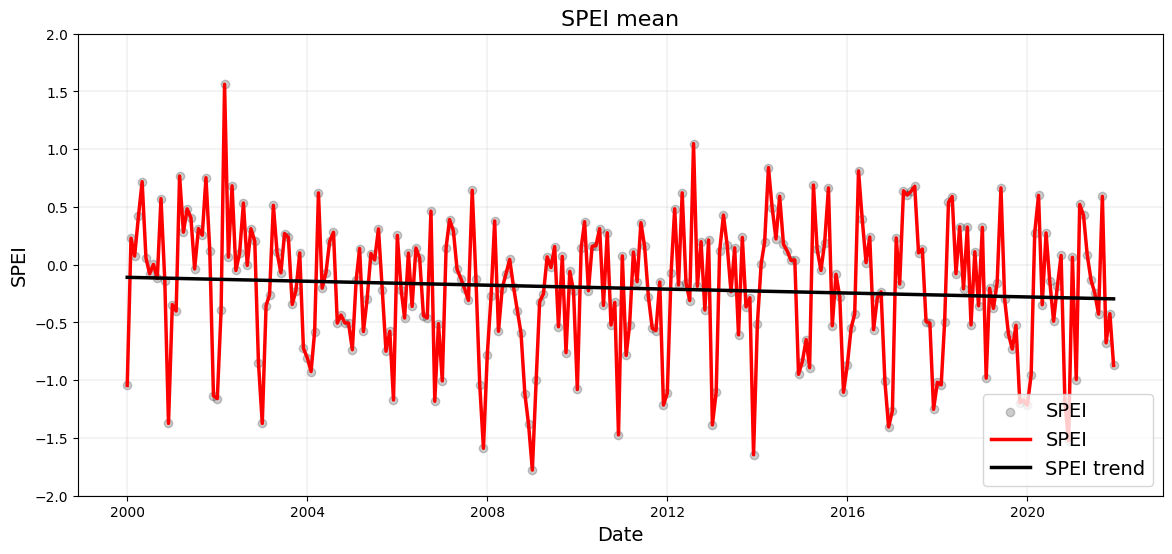

In [14]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Fitting curves.
## First, extract x values (times) from the dfs.
x_data = np.asanyarray(spei_df['time'].apply(float))  # Time

## Secondly, extract y values (SPEI) from the dfs.
y_data = np.asanyarray(spei_df['SPEI'].apply(float))  # SPEI

# Subplots.
fig, ax = plt.subplots(figsize=(14, 6))

# Add scatter plots.
ax.scatter(spei_df['datetime'], spei_df['SPEI'],
           c='black', alpha=0.2, label='SPEI')

# Add fitting curves.
ax.plot(spei_df['datetime'],
        spei_df['SPEI'],
        label='SPEI', color='red', lw=2.5)

# Add trend curves.
z = np.polyfit(list(spei_df.index), spei_df['SPEI'], 1)
p = np.poly1d(z)

ax.plot(spei_df['datetime'],
        p(spei_df.index),
        label='SPEI trend', color='black', lw=2.5)

# Add some parameters.
ax.set_title('SPEI mean', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('SPEI', fontsize=14)
ax.set_ylim(-2, 2)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='lower right')

plt.show()

In [15]:
def add_variables(image):
    time_field = 'system:time_start'
    
    date = ee.Date(image.get(time_field))
    years = date.difference(ee.Date('1970-01-01'), 'year')
    
    return image.addBands(ee.Image(years).rename('t')).float().addBands(ee.Image.constant(1))

In [16]:
time_field = 'system:time_start'
filtered_spei = dataset_spei.select('SPEI').filterBounds(roi).map(add_variables)

independents = ee.List(['constant', 't'])
dependent = ee.String('SPEI')

trend = filtered_spei.select(independents.add(dependent)).reduce(ee.Reducer.linearRegression(independents.length(), 1))
coefficients = trend.select('coefficients').arrayProject([0]).arrayFlatten([independents])

In [17]:
detrended = filtered_spei.map(lambda image: image.select(dependent).subtract(image.select(independents).multiply(coefficients).reduce('sum')).rename(dependent).copyProperties(image, [time_field]))

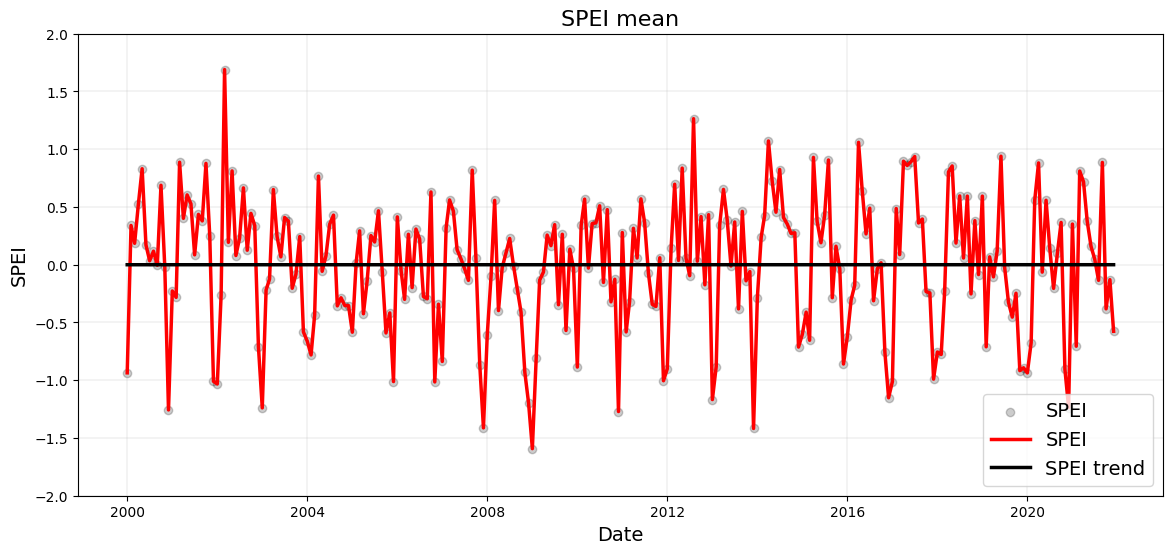

In [18]:
scale = 4638.3
detrended_spei = detrended.select('SPEI').getRegion(roi, scale).getInfo()
spei_df = ee_array_to_df(detrended_spei, ['SPEI'])

# Fitting curves.
## First, extract x values (times) from the dfs.
x_data = np.asanyarray(spei_df['time'].apply(float))  # Time

## Secondly, extract y values (SPEI) from the dfs.
y_data = np.asanyarray(spei_df['SPEI'].apply(float))  # SPEI

# Subplots.
fig, ax = plt.subplots(figsize=(14, 6))

# Add scatter plots.
ax.scatter(spei_df['datetime'], spei_df['SPEI'],
           c='black', alpha=0.2, label='SPEI')

# Add fitting curves.
ax.plot(spei_df['datetime'],
        spei_df['SPEI'],
        label='SPEI', color='red', lw=2.5)

# Add trend curves.
z = np.polyfit(list(spei_df.index), spei_df['SPEI'], 1)
p = np.poly1d(z)

ax.plot(spei_df['datetime'],
        p(spei_df.index),
        label='SPEI trend', color='black', lw=2.5)

# Add some parameters.
ax.set_title('SPEI mean', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('SPEI', fontsize=14)
ax.set_ylim(-2, 2)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='lower right')

plt.show()

1. Identificar 3 puntos de tú interés, grafique la serie temporal de la variable SPEI e identifique si existen tendencias o temporalidad en la serie.

    Vamos a analizar la zona de Villa de Totoral, Córdoba. Se visualizará como cambió el cuerpo de agua Laguna de Mar Chiquita y el dique San Roque.
    
    También se va a analizar iguazú, y la zona de cataratas para ver las variaciones en el SPEI en esa zona.
    
    Se analizará finalmente la costa este de Australia, que debería estar impactada los últimos años por el fenómeno de la niña (com impacto opuesto al de latinoamérica)

In [19]:
roi_totoral = ee.Geometry.Point([-64.05738453613687 , -30.748303581726585])
roi_iguazu = ee.Geometry.Point([-54.57690622790994, -25.613948646751236])
roi_tierra_del_fuego = ee.Geometry.Point([-70.07841920033945, -49.43880501635339])
# Tolar grande, Salta 
roi_tolar_grande = ee.Geometry.Point([-67.4021943682152, -24.59525264677601])

In [20]:
def plot_roi_trend(dataset_spei, roi, min_=-4, max_=4):
    scale = 4638.3
    spei = dataset_spei.select('SPEI').getRegion(roi, scale).getInfo()
    spei_df = ee_array_to_df(spei, ['SPEI'])
    # Fitting curves.
    ## First, extract x values (times) from the dfs.
    x_data = np.asanyarray(spei_df['time'].apply(float))  # Time

    ## Secondly, extract y values (SPEI) from the dfs.
    y_data = np.asanyarray(spei_df['SPEI'].apply(float))  # SPEI

    # Subplots.
    fig, ax = plt.subplots(figsize=(14, 6))

    # Add scatter plots.
    ax.scatter(spei_df['datetime'], spei_df['SPEI'],
               c='black', alpha=0.2, label='SPEI')

    # Add fitting curves.
    ax.plot(spei_df['datetime'],
            spei_df['SPEI'],
            label='SPEI', color='red', lw=2.5)

    # Add trend curves.
    z = np.polyfit(list(spei_df.index), spei_df['SPEI'], 1)
    p = np.poly1d(z)

    ax.plot(spei_df['datetime'],
            p(spei_df.index),
            label='SPEI trend', color='black', lw=2.5)

    # Add some parameters.
    ax.set_title('SPEI mean', fontsize=16)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('SPEI', fontsize=14)
    ax.set_ylim(min_, max_)
    ax.grid(lw=0.2)
    ax.legend(fontsize=14, loc='lower right')

    plt.show()

def plot_roi_without_trend(dataset_spei, roi, min_=-4, max_=4):
    time_field = 'system:time_start'
    filtered_spei = dataset_spei.select('SPEI').filterBounds(roi).map(add_variables)

    independents = ee.List(['constant', 't'])
    dependent = ee.String('SPEI')

    trend = filtered_spei.select(independents.add(dependent)).reduce(ee.Reducer.linearRegression(independents.length(), 1))
    coefficients = trend.select('coefficients').arrayProject([0]).arrayFlatten([independents])
    
    detrended = filtered_spei.map(lambda image: image.select(dependent).subtract(image.select(independents).multiply(coefficients).reduce('sum')).rename(dependent).copyProperties(image, [time_field]))
    scale = 4638.3
    detrended_spei = detrended.select('SPEI').getRegion(roi, scale).getInfo()
    spei_df = ee_array_to_df(detrended_spei, ['SPEI'])

    # Fitting curves.
    ## First, extract x values (times) from the dfs.
    x_data = np.asanyarray(spei_df['time'].apply(float))  # Time

    ## Secondly, extract y values (SPEI) from the dfs.
    y_data = np.asanyarray(spei_df['SPEI'].apply(float))  # SPEI

    # Subplots.
    fig, ax = plt.subplots(figsize=(14, 6))

    # Add scatter plots.
    ax.scatter(spei_df['datetime'], spei_df['SPEI'],
               c='black', alpha=0.2, label='SPEI')

    # Add fitting curves.
    ax.plot(spei_df['datetime'],
            spei_df['SPEI'],
            label='SPEI', color='red', lw=2.5)

    # Add trend curves.
    z = np.polyfit(list(spei_df.index), spei_df['SPEI'], 1)
    p = np.poly1d(z)

    ax.plot(spei_df['datetime'],
            p(spei_df.index),
            label='SPEI trend', color='black', lw=2.5)

    # Add some parameters.
    ax.set_title('SPEI mean', fontsize=16)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('SPEI', fontsize=14)
    ax.set_ylim(min_, max_)
    ax.grid(lw=0.2)
    ax.legend(fontsize=14, loc='lower right')

    plt.show()
    

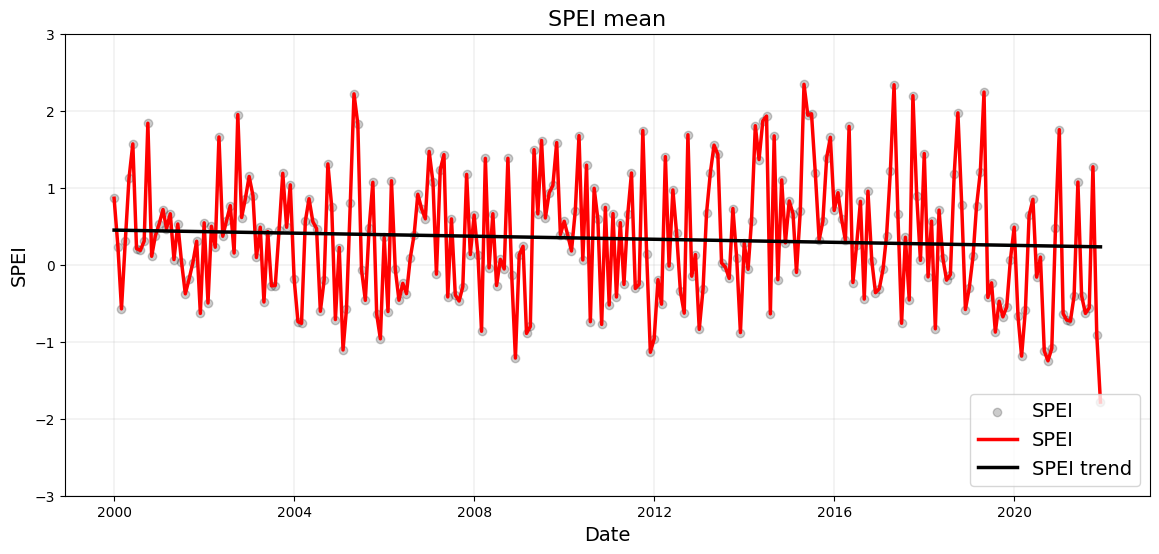

In [21]:
plot_roi_trend(dataset_spei, roi_iguazu, -3, 3)

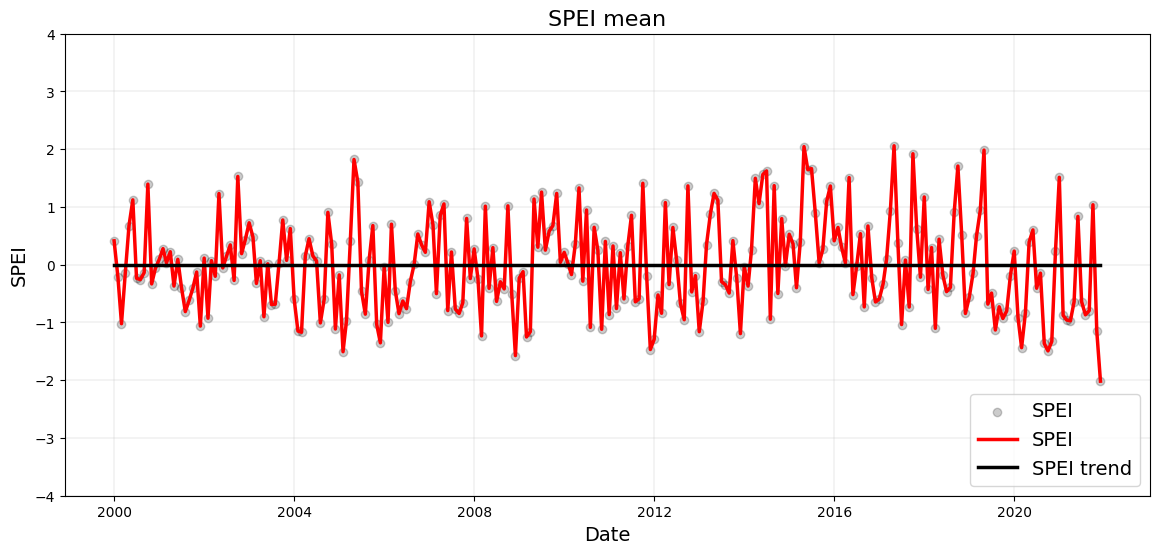

In [22]:
plot_roi_without_trend(dataset_spei, roi_iguazu)

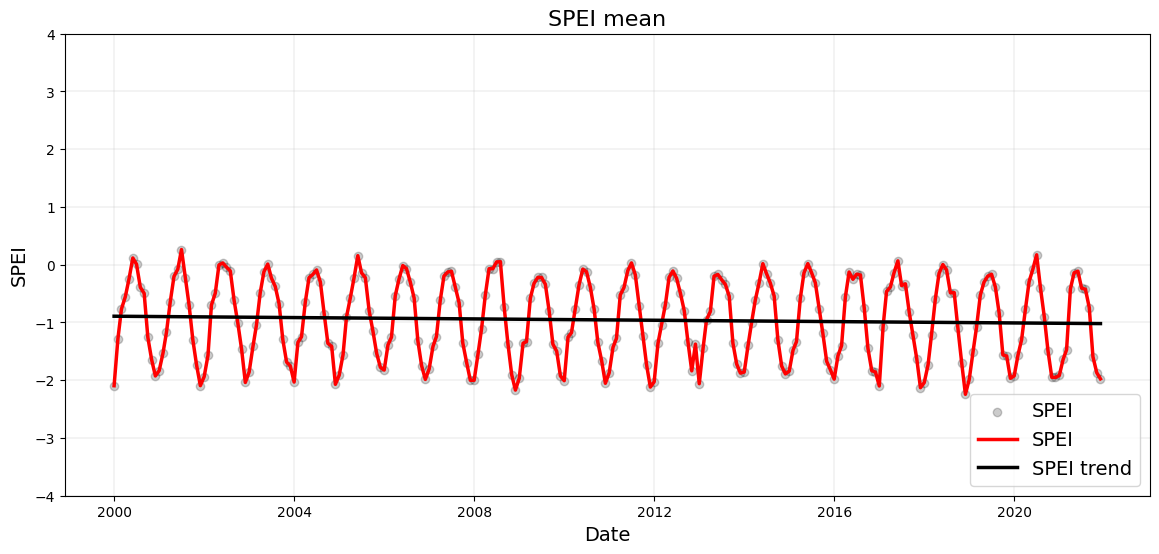

In [23]:
plot_roi_trend(dataset_spei, roi_tierra_del_fuego)

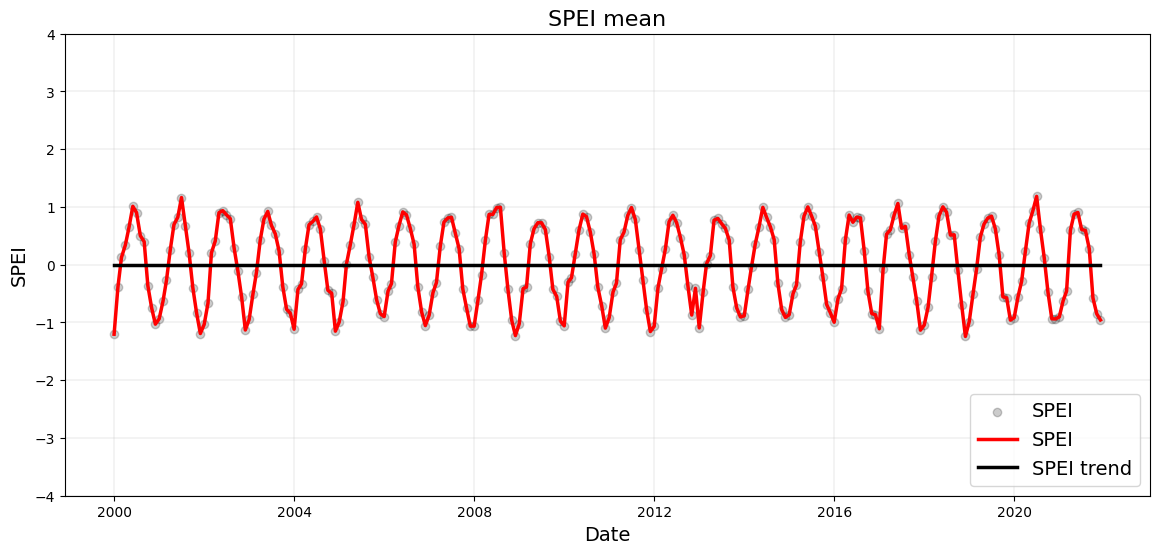

In [24]:
plot_roi_without_trend(dataset_spei, roi_tierra_del_fuego)

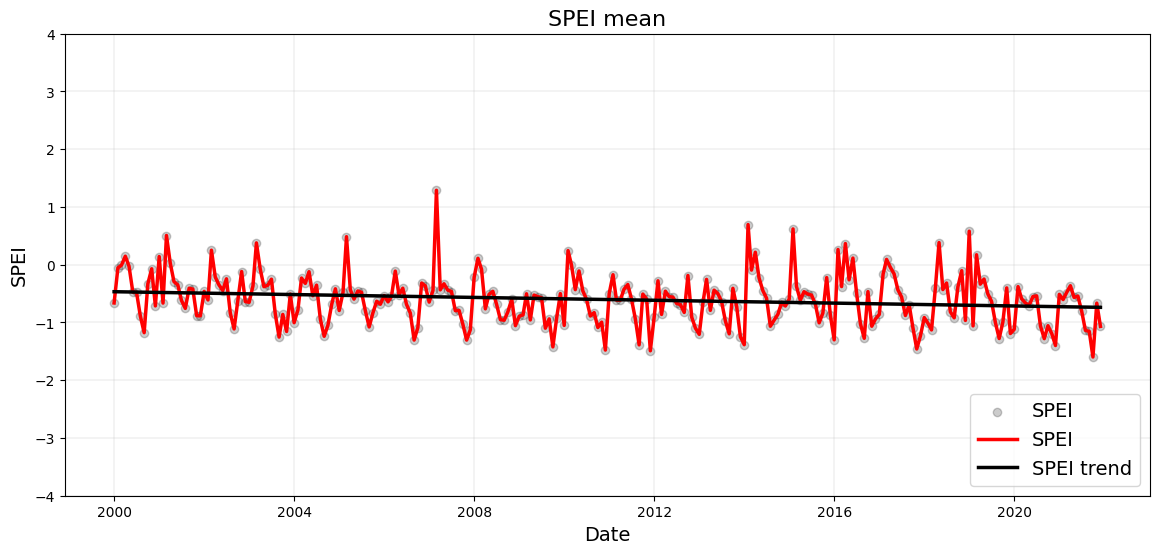

In [25]:
plot_roi_trend(dataset_spei, roi_totoral)

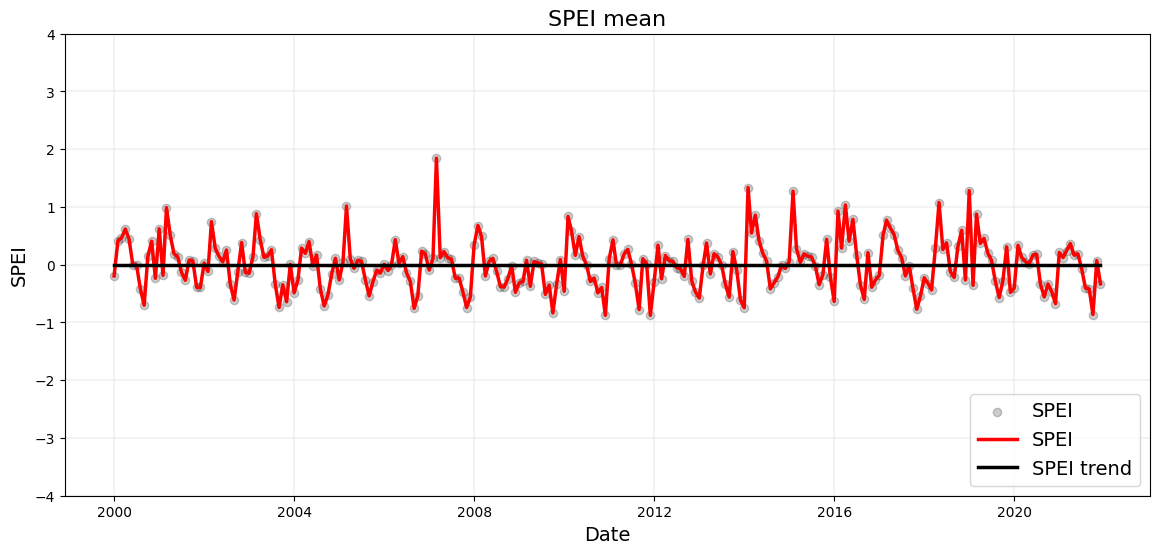

In [26]:
plot_roi_without_trend(dataset_spei, roi_totoral)

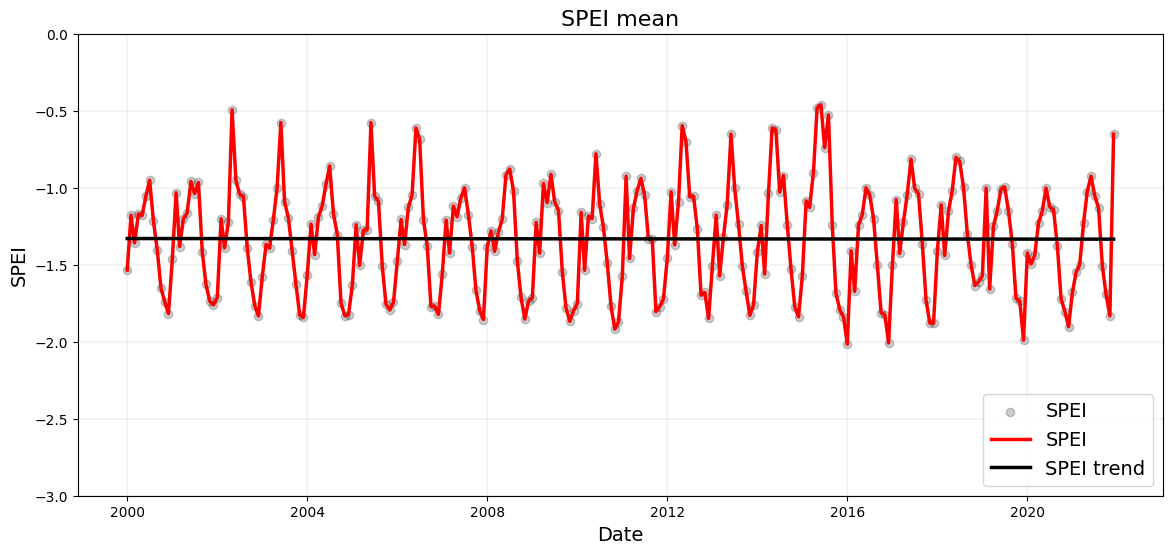

In [27]:
plot_roi_trend(dataset_spei, roi_tolar_grande, -3, 0)

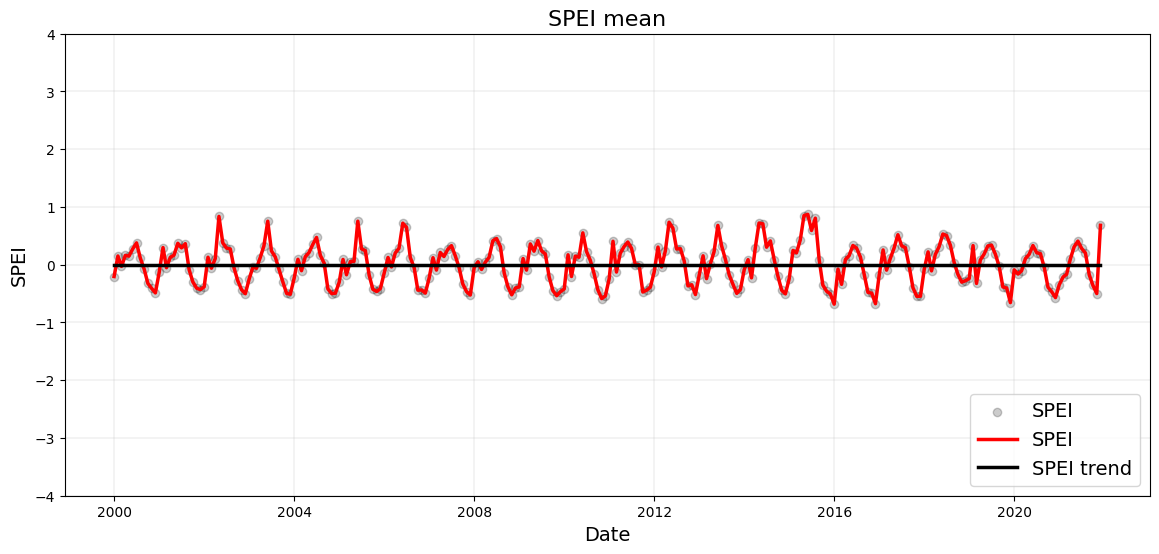

In [28]:
plot_roi_without_trend(dataset_spei, roi_tolar_grande)

In [29]:
def get_spei_df_for_roi(dataset, roi, datetime_bottom=None):
    spei = dataset.select('SPEI').getRegion(roi, scale).getInfo()
    df = ee_array_to_df(spei, ['SPEI'])
    if datetime_bottom:
        df = df[df['datetime'] > datetime_bottom]
    return df

In [30]:
import datetime

spei_iguazu = get_spei_df_for_roi(dataset_spei, roi_iguazu)
max_iguazu = spei_iguazu[spei_iguazu['SPEI'] == spei_iguazu['SPEI'].max()]
min_iguazu = spei_iguazu[spei_iguazu['SPEI'] == spei_iguazu['SPEI'].min()]

spei_totoral = get_spei_df_for_roi(dataset_spei, roi_totoral, datetime.datetime(2017, 4, 1))
max_totoral = spei_totoral[spei_totoral['SPEI'] == spei_totoral['SPEI'].max()]
min_totoral = spei_totoral[spei_totoral['SPEI'] == spei_totoral['SPEI'].min()]

spei_tolar_grande = get_spei_df_for_roi(dataset_spei, roi_tolar_grande)
max_tolar_grande = spei_tolar_grande[spei_tolar_grande['SPEI'] == spei_tolar_grande['SPEI'].max()]
min_tolar_grande = spei_tolar_grande[spei_tolar_grande['SPEI'] == spei_tolar_grande['SPEI'].min()]

In [31]:
max_iguazu

,time,datetime,SPEI
184,1430438400000,2015-05-01,2.343


In [32]:
min_iguazu

,time,datetime,SPEI
263,1638316800000,2021-12-01,-1.784


In [33]:
max_totoral

,time,datetime,SPEI
228,1546300800000,2019-01-01,0.58


In [34]:
min_totoral

,time,datetime,SPEI
261,1633046400000,2021-10-01,-1.598


In [35]:
max_tolar_grande

,time,datetime,SPEI
185,1433116800000,2015-06-01,-0.461


In [36]:
min_tolar_grande

,time,datetime,SPEI
192,1451606400000,2016-01-01,-2.016


In [37]:
sentinel_1 = ee.ImageCollection('COPERNICUS/S1_GRD').filterDate('2019-01-01', '2021-01-10')
sentinel_1 = sentinel_1.map(lambda x: clipper(x, shp_argentina))

s1_vv_vh_iw = sentinel_1.filter(
    ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')
).filter(
    ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')
).filter(ee.Filter.eq('instrumentMode', 'IW'))

s1_vv_vh_iw_asc = s1_vv_vh_iw.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
s1_vv_vh_iw_desc = s1_vv_vh_iw.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))

asc = s1_vv_vh_iw_asc
desc = s1_vv_vh_iw_desc

vv_asc = asc.select('VV')#.mean()
vv_desc = desc.select('VV')#.mean()

vh_asc = asc.select('VH').mean()
vh_desc = desc.select('VH').mean()

vv_asc_desc = vv_asc.merge(vv_desc).select('VV').mean()

def mask_image(threshold, image):
    mask = image.lte(threshold).rename('mask')
    masked_image = image.mask(mask)
    return masked_image.updateMask(mask)

lat, lon = -34.603722, -58.381592
lat, lon = -24.59525264677601, -67.4021943682152

my_map = folium.Map(location=[lat, lon], zoom_start=14)

#my_map.add_ee_layer(mask_image(-17, vv_desc), {'min': -12, 'max': -4, 'palette': ['blue']}, "Descendente VV")
#my_map.add_ee_layer(mask_image(-17, vv_asc), {'min': -12, 'max': -4, 'palette': ['blue']}, "Ascendente VV")
my_map.add_ee_layer(mask_image(-17, vv_asc_desc), {'min': -12, 'max': -4, 'palette': ['blue']}, "Ascendente Descendente VV")
my_map.add_ee_layer(shp_argentina, {}, "Argentina")
my_map.add_child(folium.LayerControl())
display(my_map)

In [38]:
GOES_16 = ee.ImageCollection('NOAA/GOES/16/MCMIPF').filterDate(start_date, end_date).map(lambda x: clipper(x, shp_argentina))

def get_h2o_area(image):
    h2o = image.select('CMI_C03').multiply(0.0002442).lte(0.06).rename('h2o_area')
    return h2o

collection_info = GOES_16.map(get_h2o_area)

vis = {
    'min': 0,
    'max': 1,
    'palette': ['FFFFFF','042333']
}

my_goes_map = folium.Map(location=[lat, lon], zoom_start=14)
my_goes_map.add_ee_layer(collection_info.filterMetadata('system:index', 'equals', '2017232122523000000').first(), vis,"GOES16")
my_goes_map.add_ee_layer(shp_argentina, {}, "Argentina")
my_goes_map.add_child(folium.LayerControl())
display(my_goes_map)

In [39]:
MOD09GA = ee.ImageCollection('MODIS/006/MOD09A1').filterDate('2021-10-01', '2021-11-30').map(lambda x: clipper(x, shp_argentina))
def to_mask(image):
    mascara = image.select('sur_refl_b02').multiply(0.0001).lte(0.09).rename('mascara')
    maskedImage = image.mask(mascara)
    return image.updateMask(mascara)
Collectioninmascara = MOD09GA.select('sur_refl_b02').map(to_mask)
my_terra_map = folium.Map(location=[lat, lon], zoom_start=14)
my_terra_map.add_ee_layer(Collectioninmascara, {'palette': ['blue']},'mascara agua MODIS')
display(my_terra_map)

In [90]:
for province in shp_argentina.getInfo()['features']:
    if province['properties']['ADMIN_NAME'].upper() == 'CORDOBA':
        cordoba = province
cordoba = shp_argentina.filter('ADMIN_NAME == "Cordoba"')

In [95]:
sd = "2019-01-01"
ed = "2019-02-28"

def get_ndvi(geometry, image):
    ndvi = image.normalizedDifference(['B8', 'B4'])
    image = image.addBands(ndvi.rename("NDVI"))
    return image.clip(geometry)

images = ee.ImageCollection("COPERNICUS/S2").filterBounds(cordoba).filterDate(sd, ed).filterMetadata("CLOUDY_PIXEL_PERCENTAGE", "less_than", 1).map(lambda x: get_ndvi(cordoba, x)).select("NDVI")
    

In [96]:
ndvi_map = folium.Map(location=[lat, lon], zoom_start=14)
ndvi_map.add_ee_layer(images.mean(), {'palette': ['red', 'yellow', 'green']},'NDVI')
ndvi_map.add_ee_layer(shp_argentina, {}, "Argentina")
ndvi_map.add_child(folium.LayerControl())
display(ndvi_map)

In [97]:
sd = "2021-10-01"
ed = "2021-10-31"
images = ee.ImageCollection("COPERNICUS/S2").filterBounds(cordoba).filterDate(sd, ed).filterMetadata("CLOUDY_PIXEL_PERCENTAGE", "less_than", 1).map(lambda x: get_ndvi(cordoba, x)).select("NDVI")

ndvi_map = folium.Map(location=[lat, lon], zoom_start=14)
ndvi_map.add_ee_layer(images.mean(), {'palette': ['red', 'yellow', 'green']},'NDVI')
ndvi_map.add_ee_layer(shp_argentina, {}, "Argentina")
ndvi_map.add_child(folium.LayerControl())
display(ndvi_map)

In [85]:
for i in shp_argentina.iterate():
    print(i)

TypeError: iterate() missing 1 required positional argument: 'algorithm'